In [1]:
from sklearn.dummy import DummyClassifier
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
import random
import copy
import time
import shutil
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from pandas import DataFrame
import seaborn as sn
import numpy as np
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler
from ipynb.fs.full._2_emnist_analyze import LeNet, Trainer
from ipynb.fs.full._8_uji_fft_angles import FNNCell
from ipynb.fs.full._6_uji_angles import CNNCell

0
None
0
None
0


/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Классов: 62
None
Классов: 62
None


/usr/lib64/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
BATCH_SIZE=50
EPOCHS=10
ACTIVATE="relu"
DROPOUT=True
BATCHNORM=True
TRACK_MAX_LEN_FFT=30
TRACK_MAX_LEN_ANGLES=3000
CURRENT_FOLDER="./"
DATASET_VARIANT="byclass"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_UJI.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_UJI.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [6]:
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print("Классов: {}".format(len(list(TRAIN_DICT.keys()))))
print(list(TRAIN_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

Классов: 62
None


In [7]:
all_size,TRAIN_DICT.keys()

(5913,
 dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'P', 'Q', 'S', 'T', 'U', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'i', 'j', 'o', 'N', 'O', 'R', 'V']))

Text(0, 0.5, 'количество образцов')

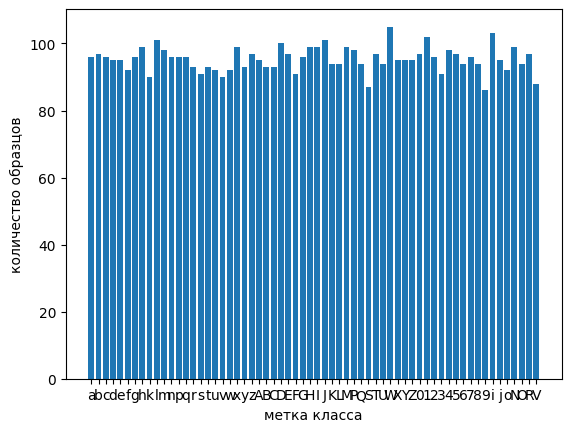

In [8]:
plt.bar( TRAIN_DICT.keys(),[len(TRAIN_DICT[key]) for key in TRAIN_DICT.keys()])
plt.xlabel("метка класса")
plt.ylabel("количество образцов")

In [9]:
class MixDataset(Dataset):

    def __init__(self, data, transform=None, data_type='fft_angles',track_max_len_fft=TRACK_MAX_LEN_FFT,track_max_len_angles=TRACK_MAX_LEN_ANGLES):
        str="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.type=data_type
        self.track_max_len_angles=track_max_len_angles
        self.track_max_len_fft=track_max_len_fft
        self.data=np.array([])
        for key in data.keys():
            for ch in data[key]:
                if key in str:
                    self.data=np.append(self.data,[ch])              
        self.classes=list(str)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_ix_fft = np.zeros([self.track_max_len_fft], dtype='float32')
        data_ix_angles = np.zeros([self.track_max_len_angles], dtype='float32')
        vec_angles=self.data[idx].singlePolys().angles
        vec_fft=self.data[idx].singlePolys().fft_angles
            # ограничим длинну трека
        data_ix_fft[:len(vec_fft)] = vec_fft[:self.track_max_len_fft]
        data_ix_angles[:len(vec_angles)] = vec_angles[:self.track_max_len_angles]
        img=self.data[idx].singleImage()
        array = np.array(img, dtype=np.uint8)
        img = Image.fromarray(array)
        if self.transform:
            img = self.transform(img)
        class_num=self.classes.index(self.data[idx].name)
        return torch.Tensor(data_ix_fft),torch.Tensor(data_ix_angles), img,class_num

In [10]:
vec_datasets = {"train": MixDataset(TRAIN_DICT, data_type='fft_angles',transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomRotation(degrees=(-90,-90)),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Resize(32),            
                                                                     # transforms.Pad(2),                                                   
                                                                    transforms.ToTensor()])),
                 "val":MixDataset(TEST_DICT, data_type='fft_angles',transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                                                    transforms.RandomRotation(degrees=(-90,-90)),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                     transforms.Resize(32),            
                                                                     # transforms.Pad(2),                                                   
                                                                    transforms.ToTensor()]))}
dataloaders = {"train": torch.utils.data.DataLoader(vec_datasets["train"], batch_size=BATCH_SIZE,shuffle=True),
               "val": torch.utils.data.DataLoader(vec_datasets["val"], batch_size=BATCH_SIZE,shuffle=True),
}
dataset_sizes = {x: len(vec_datasets[x]) for x in ['train', 'val']}
classes_names = {x: vec_datasets[x].classes for x in ['train', 'val']}

In [11]:
tr=Trainer()
fcnet=FNNCell(track_max_len=TRACK_MAX_LEN_FFT,num_classes=len(vec_datasets["train"].classes)).to(device)
lenet = LeNet(num_classes=len(vec_datasets["train"].classes)).to(device)
cnnnet=CNNCell(num_classes=len(vec_datasets["train"].classes)).to(device)

In [12]:
fcnet.load_state_dict(torch.load("models/uji_fft_fcnet_"+DATASET_VARIANT+".pt"))
lenet.load_state_dict(torch.load("models/uji_img_fcnet_"+DATASET_VARIANT+".pt"))
cnnnet.load_state_dict(torch.load("models/uji_angles_cnnnet_"+DATASET_VARIANT+".pt"))

<All keys matched successfully>

In [13]:
criterion = nn.CrossEntropyLoss()
_preds_fcnet=np.array([])
_preds_cnnnet=np.array([])
_preds_lenet=np.array([])
_preds_ensemble1=np.array([])
_preds_ensemble2=np.array([])
_preds_ensemble3=np.array([])
_targets=np.array([])
_loss_fcnet=0
_loss_cnnnet=0
_loss_lenet=0
_loss_ensemble1=0
_loss_ensemble2=0
_loss_ensemble3=0
for tracks_fft, tracks_angles, images, labels in dataloaders['val']:    # Iterate over data.
    tracks_fft = tracks_fft.to(device)
    tracks_angles = tracks_angles.to(device)
    images = images.to(device)
    labels = labels.to(device)
    outputs_fcnet = fcnet(tracks_fft)
    outputs_cnnnet = cnnnet(tracks_angles)
    outputs_lenet = lenet(images)
    outputs_ensemble1=(outputs_fcnet+outputs_lenet)/2
    outputs_ensemble2=(outputs_cnnnet+outputs_lenet)/2
    outputs_ensemble3=(outputs_fcnet+outputs_cnnnet+outputs_lenet)/3
    
    _loss_fcnet += criterion(outputs_fcnet,labels).item()*tracks_fft.size(0)
    _loss_cnnnet += criterion(outputs_cnnnet,labels).item()*tracks_angles.size(0)
    _loss_lenet += criterion(outputs_lenet,labels).item()*images.size(0)
    _loss_ensemble1 += criterion(outputs_ensemble1,labels).item()*images.size(0)
    _loss_ensemble2 += criterion(outputs_ensemble2,labels).item()*images.size(0)
    _loss_ensemble3 += criterion(outputs_ensemble3,labels).item()*images.size(0)
    
    _, preds_fcnet = torch.max(outputs_fcnet, 1)
    _, preds_cnnnet = torch.max(outputs_cnnnet, 1)
    _, preds_lenet = torch.max(outputs_lenet, 1)
    _, preds_ensemble1= torch.max(outputs_ensemble1, 1)
    _, preds_ensemble2= torch.max(outputs_ensemble2, 1)
    _, preds_ensemble3= torch.max(outputs_ensemble3, 1)
    _targets=np.append(_targets, labels.detach().cpu().numpy())
    _preds_fcnet=np.append(_preds_fcnet,preds_fcnet.detach().cpu().numpy())
    _preds_cnnnet=np.append(_preds_cnnnet,preds_cnnnet.detach().cpu().numpy())
    _preds_lenet=np.append(_preds_lenet,preds_lenet.detach().cpu().numpy())
    _preds_ensemble1=np.append(_preds_ensemble1,preds_ensemble1.detach().cpu().numpy())
    _preds_ensemble2=np.append(_preds_ensemble2,preds_ensemble2.detach().cpu().numpy())
    _preds_ensemble3=np.append(_preds_ensemble3,preds_ensemble3.detach().cpu().numpy())
    

--->   torch.Size([50, 1, 256])
--->   torch.Size([50, 1, 256])
--->   torch.Size([50, 1, 256])
--->   torch.Size([50, 1, 256])
====
--->   torch.Size([50, 1, 128])
--->   torch.Size([50, 1, 128])
--->   torch.Size([50, 1, 128])
--->   torch.Size([50, 1, 128])
====
--->   torch.Size([50, 20, 2998])
--->   torch.Size([50, 20, 2998])
--->   torch.Size([50, 20, 1499])
--->   torch.Size([50, 20, 1499])
--->   torch.Size([50, 20, 1499])
====
--->   torch.Size([50, 30, 1497])
--->   torch.Size([50, 30, 1497])
--->   torch.Size([50, 30, 748])
--->   torch.Size([50, 30, 748])
--->   torch.Size([50, 30, 748])
====
--->   torch.Size([50, 40, 746])
--->   torch.Size([50, 40, 746])
--->   torch.Size([50, 40, 106])
--->   torch.Size([50, 40, 106])
--->   torch.Size([50, 40, 106])
====


/usr/lib64/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [14]:
print("Loss по FFT траекторий: {}".format(_loss_fcnet/dataset_sizes["val"]))
print("Loss по углам траекторий: {}".format(_loss_cnnnet/dataset_sizes["val"]))
print("Loss по изображениям: {}".format(_loss_lenet/dataset_sizes["val"]))
print("Loss по ансамблю моделей (FFT+IMG): {}".format(_loss_ensemble1/dataset_sizes["val"]))
print("Loss по ансамблю моделей (ANLES+IMG): {}".format(_loss_ensemble2/dataset_sizes["val"]))
print("Loss по ансамблю моделей (FFT+ANLES+IMG): {}".format(_loss_ensemble3/dataset_sizes["val"]))

Loss по FFT траекторий: 2.46547869864678
Loss по углам траекторий: 1.4509550468080092
Loss по изображениям: 1.230381483335314
Loss по ансамблю моделей (FFT+IMG): 1.0920602480960813
Loss по ансамблю моделей (ANLES+IMG): 0.8305065904322526
Loss по ансамблю моделей (FFT+ANLES+IMG): 0.8349650917915089


In [15]:
(1.3518828605621878+0.6735461965525315)/2  # (FFT+IMG)

1.0127145285573596

In [16]:
(0.8030652861698203+0.6735461965525315)/2  # (ANLES+IMG)

0.7383057413611759

In [17]:
print("Точность предсказания по FFT траекторий: {}".format(sum(_targets==_preds_fcnet)/len(_targets)))
print("Точность предсказания по углам траекторий: {}".format(sum(_targets==_preds_cnnnet)/len(_targets)))
print("Точность предсказания по изображениям: {}".format(sum(_targets==_preds_lenet)/len(_targets)))
print("Точность предсказания по ансамблю моделей (FFT+IMG): {}".format(sum(_targets==_preds_ensemble1)/len(_targets)))
print("Точность предсказания по ансамблю моделей (ANLES+IMG): {}".format(sum(_targets==_preds_ensemble2)/len(_targets)))
print("Точность предсказания по ансамблю моделей (FFT+ANLES+IMG): {}".format(sum(_targets==_preds_ensemble3)/len(_targets)))

Точность предсказания по FFT траекторий: 0.32481990831696134
Точность предсказания по углам траекторий: 0.5848068107400131
Точность предсказания по изображениям: 0.618860510805501
Точность предсказания по ансамблю моделей (FFT+IMG): 0.6810740013097577
Точность предсказания по ансамблю моделей (ANLES+IMG): 0.7295350360183366
Точность предсказания по ансамблю моделей (FFT+ANLES+IMG): 0.741977734119188


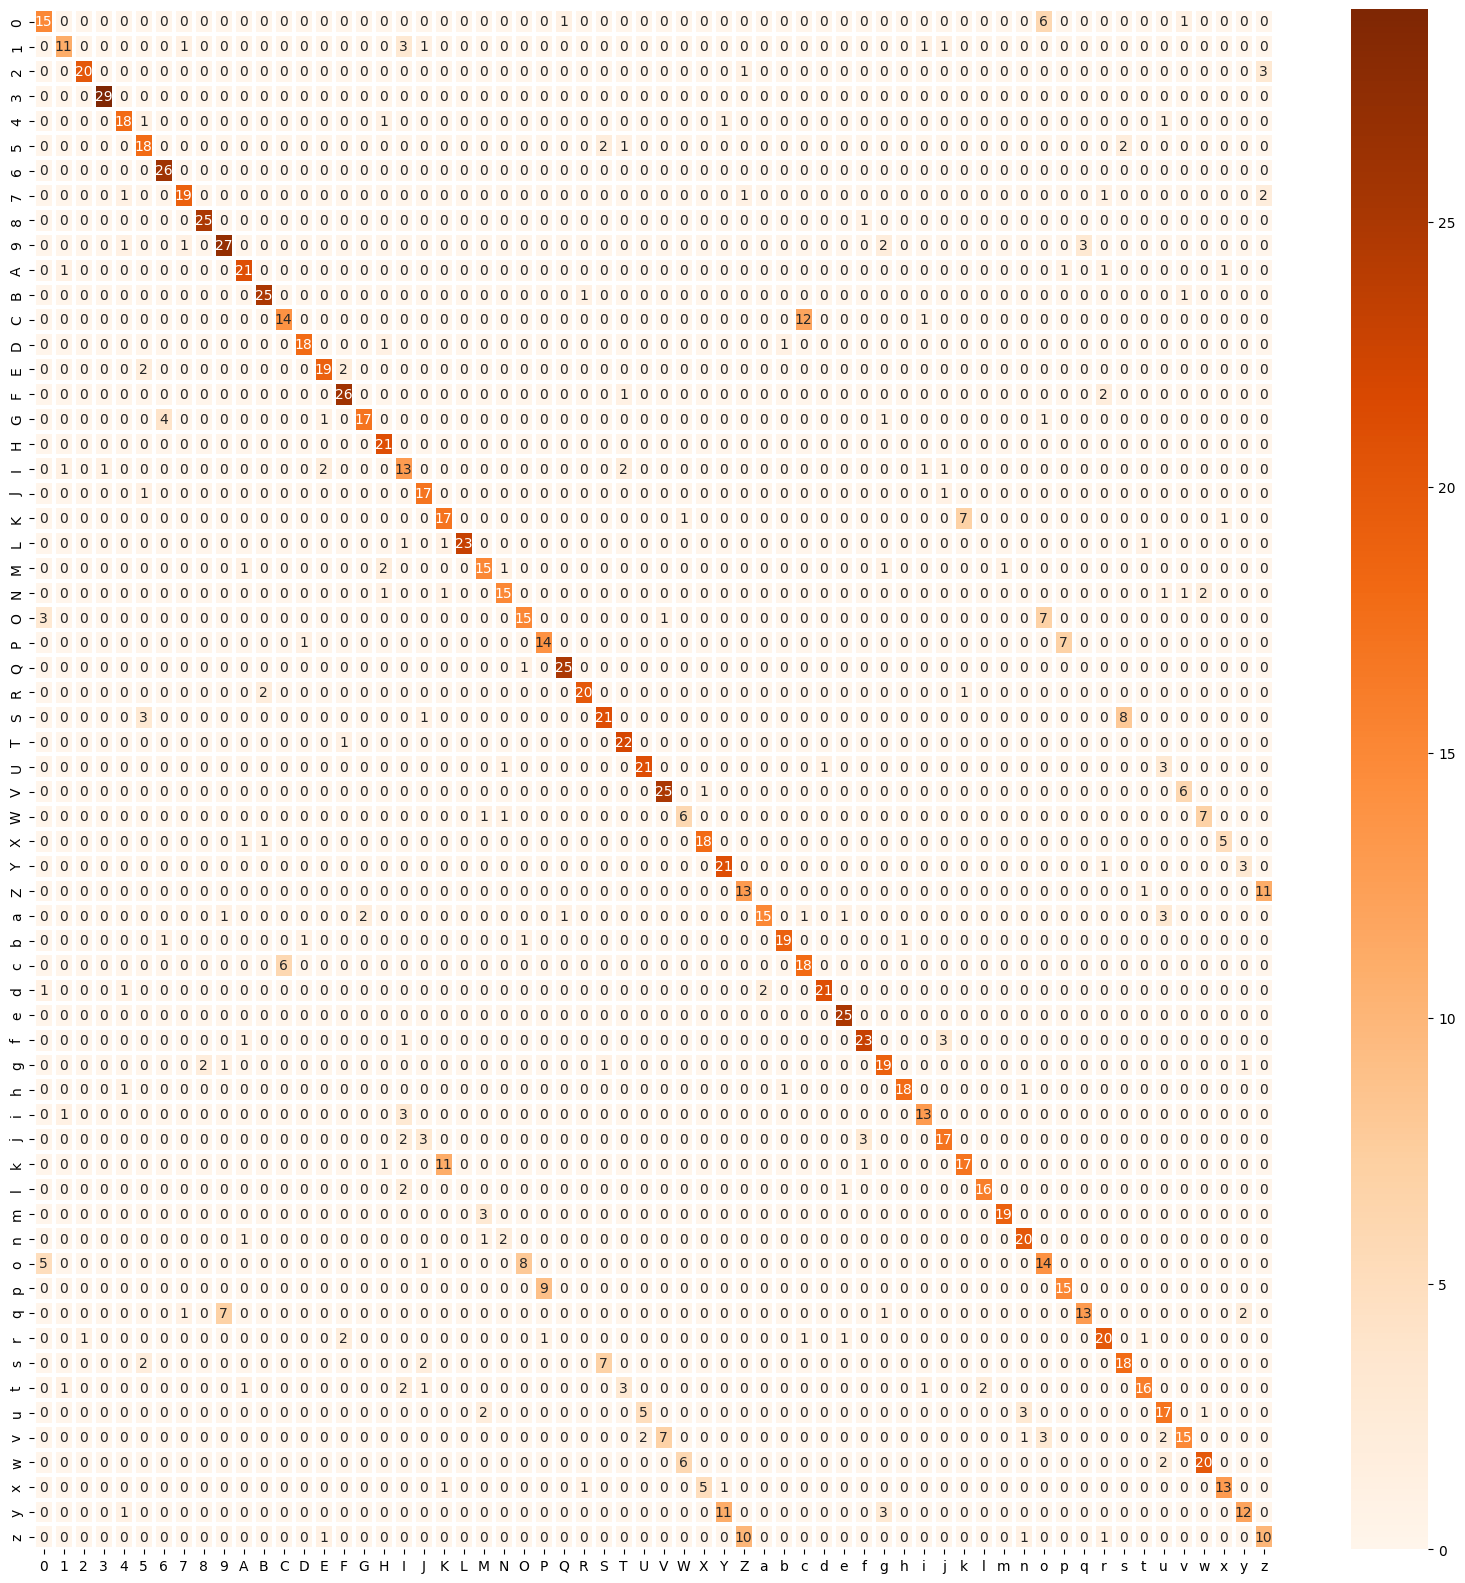

In [18]:
cm=metrics.confusion_matrix(_targets,_preds_ensemble3)
df_cm = DataFrame(cm, index=classes_names["val"], columns=classes_names["val"])
from pandas import DataFrame
import seaborn as sn
plt.subplots(figsize=(20,20))
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/Ensemble_uji_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()